In [1]:
'''
This is a sample analysis for the audience dataset from this pipeline.
I tested a simple analysis, the effect of Weekdays vs. Weekends on
elapsed time spent watching TV. The analysis was performed as a
simple linear regression, broken into a train set and test set, 
where the predictor weekday vs. weekend was contrast coded, and
the outcome variable, elapsed time was measured in minutes.

I provided an additional, more sophisticated analysis, a multiple
regression with ridge regularization. However, due to time and
computational limitations this analysis is more a proof of concept,
using only a subset of the full sample.
'''

'\nThis is a sample analysis for the audience dataset from this pipeline.\nI tested a simple analysis, the effect of Weekdays vs. Weekends on\nelapsed time spent watching TV. The analysis was performed as a\nsimple linear regression, broken into a train set and test set, \nwhere the predictor weekday vs. weekend was contrast coded, and\nthe outcome variable, elapsed time was measured in minutes.\n'

In [45]:
'''
Analysis Code Requirements
python3
ConfigParser
psycopg2
numpy
sklearn
matplotlib
'''

'\nAnalysis Code Requirements\npython3\nConfigParser\npsycopg2\nnumpy\nsklearn\nmatplotlib\n'

In [2]:
#!/usr/bin/env py
'''
Set dependencies and python shebang
'''
from configpath import configpath  # Config path
from configparser import ConfigParser  # Load config
from psycopg2 import connect  # Connect to database
import numpy as np  # Arrays for stats
from sklearn.linear_model import LinearRegression  # Linear Regression
from sklearn.linear_model import Ridge  # Ridge Regression
from sklearn.model_selection import train_test_split  # Train-test
import matplotlib.pyplot as plt  # plotting
%matplotlib inline
plt.style.use('ggplot')


In [3]:
def load_config(configpath, section):
    '''
    Use configparser to load the .ini file
    '''
    parser = ConfigParser()  # Create parser
    parser.read(configpath)  # Read config ini file
    config = {}  # Create empty dictionary for config
    if parser.has_section(section):  # Look for 'config' section in config ini file
        params = parser.items(section)  # Parse config ini file
        for param in params:  # Loop through parameters
            config[param[0]] = param[1]  # Set key-value pair for parameter in dictionary
    else:  # Raise exception if the section can't be found
        raise Exception(
            'Section {0} not found in the {1} file'.format(section, configpath))
    return config

In [4]:
def create_connector(con_config, db_config):
    '''
    Create psycopg2 connector for database
    '''
    con = connect(database=db_config['dbname'], port=con_config['port'],
                  user=con_config['user'], password=con_config['password'],
                  host=con_config['host'])
    return con

In [5]:
def execute_query(con, query):
    '''
    Execute an inputted query on the connected database, fetch the result,
    and return it
    '''
    try:
        cur = con.cursor()
        cur.execute(query)
        result = cur.fetchall()
        result = [item for t in result for item in t]  # Unpack tuples
        cur.close()
        return result
    except:  # If there is an error, close cursor and reset connection
        cur.close()
        create_connector(con_config, db_config)

In [6]:
def divide_chunks(l, n):
    '''
    Chunk list l into nested lists of size n.
    '''
    for i in range(0, len(l), n):  
        yield l[i:i + n] 

In [7]:
'''
Load configs and create connection object
'''
con_config = load_config(configpath, 'postgres_connection')  # Load postgres connection config
db_config = load_config(configpath, 'createdb')  # Load database config
con = create_connector(con_config, db_config)  # Create database connector

In [8]:
'''
Create linear model object and other necessary statistics objects
'''
lr = LinearRegression()
rr = Ridge(alpha=1.0)

In [9]:
'''
Start with a simple analysis.
Test whether there is a difference between elapsed tv time for weekdays vs. weekends.
Query dataset, chunk rows into nested lists, and convert to numpy array.
Innermost statement is the SQL query.
Following that is the number of chunks, which is the number of variables fetched from the database.
Next is to pack those observation-level lists into a master-list.
The list of lists is then converted into a numpy array.
Convert estimated time from ms to minutes.
Contrast-code weekday/weekend. 
'''
dataset = np.array(list(divide_chunks(execute_query(con, "SELECT CAST(tv_data_sample.elapsed_time AS numeric), tv_data_sample.week_day_end FROM tv_data_sample;"), 2)))
dataset[:,1] = np.where(dataset[:,1]=='Weekday', 0.5, dataset[:,1])  # Contrast code weekday
dataset[:,1] = np.where(dataset[:,1]=='Weekend', -0.5, dataset[:,1])  # Contrast code weekend
dataset[:,0] = (dataset[:,0].astype(float)/1000)/60  # Convert elapsed time from ms to minutes

There are 354086 Weekday observations
Mean Weekday elapsed time is 15.79
Standard deviation Weekday elapsed time is 20.63

There are 145919 Weekday observations
Mean Weekend elapsed time is 18.04
Standard deviation Weekend elapsed time is 25.68

There appears to be an imbalanced N for weekends vs weekdays. For now they will be left as-is.


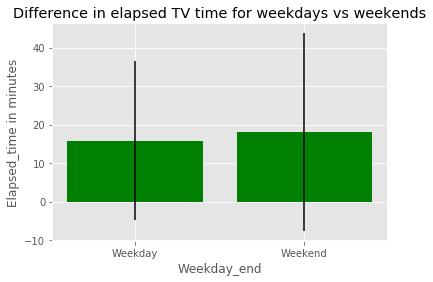

In [10]:
'''
Descriptive stats and data visualization.
'''
print("There are " + str(dataset[np.where(dataset[:,1] == 0.5),0].size) + " Weekday observations")
print("Mean Weekday elapsed time is " + str(round(dataset[np.where(dataset[:,1] == 0.5),0].mean(), 2)))
print("Standard deviation Weekday elapsed time is " + str(round(dataset[np.where(dataset[:,1] == 0.5),0].std(), 2)))
print("")
print("There are " + str(dataset[np.where(dataset[:,1] == -0.5),0].size) + " Weekday observations")
print("Mean Weekend elapsed time is " + str(round(dataset[np.where(dataset[:,1] == -0.5),0].mean(), 2)))
print("Standard deviation Weekend elapsed time is " + str(round(dataset[np.where(dataset[:,1] == -0.5),0].std(), 2)))
print("")
print("There appears to be an imbalanced N for weekends vs weekdays. For now they will be left as-is.")

x_labels = ['Weekday', 'Weekend']
y_means = [dataset[np.where(dataset[:,1] == 0.5),0].mean(), dataset[np.where(dataset[:,1] == -0.5),0].mean()]
errors = [dataset[np.where(dataset[:,1] == 0.5),0].std(), dataset[np.where(dataset[:,1] == -0.5),0].std()]

x_pos = [i for i, _ in enumerate(x_labels)]

plt.bar(x_pos, y_means, yerr=errors, color='green')
plt.xlabel("Weekday_end")
plt.ylabel("Elapsed_time in minutes")
plt.title("Difference in elapsed TV time for weekdays vs weekends")

plt.xticks(x_pos, x_labels)

plt.show()


In [12]:
'''
Test whether there is a difference between elapsed tv time for weekdays vs. weekends.
Create linear model with 80% test, 20% train. (This may be overkill for a simple model, but just as a demonstration /
arguably best practice to test for overfit and performance)
Use model to make prediction for test set.
'''

X_train, X_test, y_train, y_test = train_test_split(dataset[:,1].reshape(-1,1), dataset[:,0], test_size=0.2, random_state=0)

lr.fit(X_train, y_train, sample_weight=None)

y_pred = lr.predict(X_test)

print("Intercept: " + str(lr.intercept_))
print("Slope: " + str(lr.coef_))
print("R^2 Explained Variance Train set: " + str(lr.score(X_train, y_train)))
print("Model Performance: " + str(round(lr.score(X_test, y_test)*100,2)) + "% Accuracy")
print("These results suggest that whether or not it is a weekday vs. a weekend explains only a small amount of variance in elapsed time watching TV. On weekdays, people watched ~2.2 minutes less TV than on weekends.")
print("While model performance accuracy on the test set was low, it was consistent with the explained variance of the training set, which does not suggest that the model was ill-fit for the test set.")

Intercept: 16.906826924770748
Slope: [-2.25475838]
R^2 Explained Variance Train set: 0.0021245651677536115
Model Performance: 0.21% Accuracy
These results suggest that whether or not it is a weekday vs. a weekend explains only a small amount of variance in elapsed time watching TV. On weekdays, people watched ~2.2 minutes less TV than on weekends.
While model performance accuracy on the test set was low, it was consistent with the explained variance of the training set, which does not suggest that the model was ill-fit for the test set.


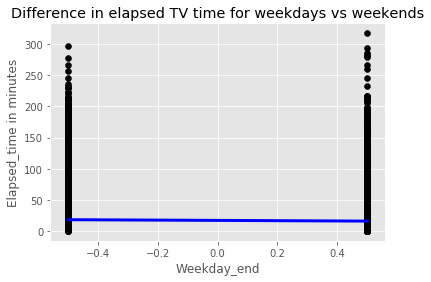

This plot shows the datapoints for elapsed time for weekends vs weekdays, similar to the bar graph but showing all observations in a scatterplot.
The blue line shows the model prediction, the least squares line of best fit.
It appears there may have been some outliers. Future analyses should correct for outliers.


In [13]:
# Plot outputs
plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=3)

plt.xlabel("Weekday_end")
plt.ylabel("Elapsed_time in minutes")
plt.title("Difference in elapsed TV time for weekdays vs weekends")

plt.show()

print("This plot shows the datapoints for elapsed time for weekends vs weekdays, similar to the bar graph but showing all observations in a scatterplot.")
print("The blue line shows the model prediction, the least squares line of best fit.")
print("It appears there may have been some outliers. Future analyses should correct for outliers.")

In [18]:
'''
This is a somewhat more sophisticated analysis. It controls for show duration, as well as total minutes spent on apps and
total minutes spent on the web, which were joined from the app_data_sample and web_data_sample, respectively. Additionally,
this model includes a ridge regularization parameter. The full data were too large for my computer, so I grabbed just a subset.
'''
dataset = np.array(list(divide_chunks(execute_query(con, "SELECT CAST(tv_data_sample.elapsed_time AS numeric), tv_data_sample.week_day_end, CAST(tv_data_sample.show_duration AS numeric), CAST(app_data_sample.total_minutes AS numeric) AS appmins, CAST(web_data_sample.total_minutes AS numeric) AS webmins FROM tv_data_sample INNER JOIN app_data_sample ON tv_data_sample.users_meta_id = app_data_sample.users_meta_id INNER JOIN web_data_sample ON tv_data_sample.users_meta_id = web_data_sample.users_meta_id LIMIT 10000;"), 5)))
dataset[:,1] = np.where(dataset[:,1]=='Weekday', 0.5, dataset[:,1])  # Contrast code weekday
dataset[:,1] = np.where(dataset[:,1]=='Weekend', -0.5, dataset[:,1])  # Contrast code weekend
dataset[:,0] = (dataset[:,0].astype(float)/1000)/60  # Convert elapsed time from ms to minutes
dataset[:,2] = (dataset[:,2].astype(float)/1000)/60  # Convert show_duration from ms to minutes

In [44]:
'''
Run ridge regression
'''
X_train, X_test, y_train, y_test = train_test_split(dataset[:,1:].reshape(dataset[:,1:].size//4,4), dataset[:,0], test_size=0.2, random_state=0)

rr.fit(X_train, y_train, sample_weight=None)

y_pred = rr.predict(X_test)

print("Intercept: " + str(rr.intercept_))
print("Slope: " + str(rr.coef_))
print("R^2 Explained Variance Train set: " + str(rr.score(X_train, y_train)))
print("Model Performance: " + str(round(rr.score(X_test, y_test)*100,2)) + "% Accuracy")
print("")
print("Compared to the simple linear regression, this ridge multiple regression provides better model performance.")
print("This model explains 47% of the variance in the training set, and had ~45% performance accuracy for the test set.")
print("This model predicts a ~4.22 minute decrease in average elapsed tv time for weekdays compared to weekends.")
print("This is controlling for show duration, time in minutes spent on apps, and time in minutes spent on the web, none of which appear to have large effects.")

Intercept: -15.052599291574863
Slope: [-4.21990786  0.48674014 -0.07303999 -0.98998913]
R^2 Explained Variance Train set: 0.47286918519134996
Model Performance: 44.96% Accuracy

Compared to the simple linear regression, this ridge multiple regression provides better model performance.
This model explains 47% of the variance in the training set, and had ~45% performance accuracy for the test set.
This model predicts a ~4.22 minute decrease in average elapsed tv time for weekdays compared to weekends.
This is controlling for show duration, time in minutes spent on apps, and time in minutes spent on the web, none of which appear to have large effects.
